In [47]:
# packages

import os
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn import svm
from sklearn.utils import shuffle
from tabulate import tabulate as tab

#### Preprocessing

In [32]:
# defining path

dataset = 'OAS2_RAW_PART1/'
excel_file = pd.read_excel('oasis_longitudinal_demographics.xlsx')

In [33]:
# defining different shapes for the images

full = pd.IndexSlice[:, :, :, 0]
half = pd.IndexSlice[::2, ::2, ::2, 0]
fourth = pd.IndexSlice[::4, ::4, ::4, 0]
eigth = pd.IndexSlice[::8, ::8, ::8, 0]
sixteenth = pd.IndexSlice[::16, ::16, ::16, 0]

full_shape = (256*256*128)
half_shape = (128*128*64)
fourth_shape = (64*64*32)
eigth_shape = (32*32*16)
sixteenth_shape = (16*16*8)

In [34]:
# opening reference excel file

data = pd.DataFrame(excel_file)

data.insert(15, 'Images', '')

data.insert(16, 'Cropped_1', '')
data.insert(17, 'Cropped_2', '')
data.insert(18, 'Cropped_3', '')
data.insert(19, 'Cropped_4', '')
data.insert(20, 'Cropped_5', '')
data.insert(21, 'Cropped_6', '')
data.insert(22, 'Cropped_7', '')
data.insert(23, 'Cropped_8', '')

data.insert(24, 'Cropped_1_1', '')
data.insert(25, 'Cropped_1_2', '')
data.insert(26, 'Cropped_1_3', '')
data.insert(27, 'Cropped_1_4', '')

# adding each (feature-reduced) image to the dataframe
for index, row in data.iterrows():
    for image in os.scandir(dataset+row['MRI ID']+'/RAW'):
        if image.name.endswith('img'):
            img = nib.load(image)
            data.at[index, 'Images'] = img.get_fdata()[fourth] # feature reduction
        # break because memory gets too large if every picture is added
        break

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336 entries, 0 to 372
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Subject ID   336 non-null    object 
 1   MRI ID       336 non-null    object 
 2   Group        336 non-null    object 
 3   Visit        336 non-null    int64  
 4   MR Delay     336 non-null    int64  
 5   M/F          336 non-null    object 
 6   Hand         336 non-null    object 
 7   Age          336 non-null    int64  
 8   EDUC         336 non-null    int64  
 9   SES          317 non-null    float64
 10  MMSE         334 non-null    float64
 11  CDR          336 non-null    float64
 12  eTIV         336 non-null    float64
 13  nWBV         336 non-null    float64
 14  ASF          336 non-null    float64
 15  Images       336 non-null    object 
 16  Cropped_1    336 non-null    object 
 17  Cropped_2    336 non-null    object 
 18  Cropped_3    336 non-null    object 
 19  Cropped_

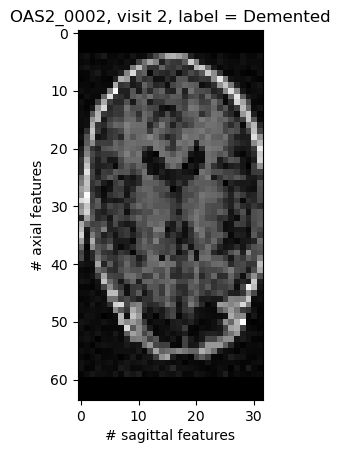

In [113]:
# info of put-together dataframe
print(data.info())

# plot example:
plt.imshow(data.iloc[3]['Images'][:, 40, :], cmap='gray')
plt.ylabel('# axial features')
plt.xlabel('# sagittal features')
plt.title(f"{data.iloc[3]['Subject ID']}, visit {data.iloc[3]['Visit']}, label = {data.iloc[3]['Group']}")
plt.show()

In [57]:
# creating table for data description

rows = [['Subject ID', 'The code that a participant is assigned to. E.g., OAS2_0001.'],
        ['MRI ID', 'The code that describes the MR session. E.g., OAS2_0001_MR1.'],
        ['Group', 'Describes the Alzheimer state of the participant at the moment of the scan session. Either Demented or Nondemented.'],
        ['Visit', 'Corresponds with MRI ID. E.g., visit = 3.'],
        ['Images', 'Contains the images in the form of a numpy array.'],
        ['Cropped [1-8]', 'Every cropped picture has its own column, it contains a certain voxel space of the full sized images, also in numpy array format.']]
col_names = ['Feature', 'Description']

df = pd.DataFrame(data=rows, columns=col_names)
print(df)

df.to_csv('Table1.csv', index=False)

         Feature                                        Description
0     Subject ID  The code that a participant is assigned to. E....
1         MRI ID  The code that describes the MR session. E.g., ...
2          Group  Describes the Alzheimer state of the participa...
3          Visit          Corresponds with MRI ID. E.g., visit = 3.
4         Images  Contains the images in the form of a numpy array.
5  Cropped [1-8]  Every cropped picture has its own column, it c...


In [36]:
# cropping images and adding to data, full shape = (64, 64, 32)

for index, row in data.iterrows():
                                  
    img1 = data.iloc[index]['Images'][32:65, 0:32, 16:33]
    data.at[index, 'Cropped_1'] = img1
                                   
    img2 = data.iloc[index]['Images'][32:65, 32:65, 0:16]
    data.at[index, 'Cropped_2'] = img2
                                    
    img3 = data.iloc[index]['Images'][32:65, 32:65, 16:33]
    data.at[index, 'Cropped_3'] = img3
    
    img4 = data.iloc[index]['Images'][0:32, 32:65, 0:16]
    data.at[index, 'Cropped_4'] = img4
                     
    img5 = data.iloc[index]['Images'][0:32, 0:32, 16:33]
    data.at[index, 'Cropped_5'] = img5
                                   
    img6 = data.iloc[index]['Images'][0:32, 0:32, 0:16]
    data.at[index, 'Cropped_6'] = img6
    
    img7 = data.iloc[index]['Images'][32:65, 0:32, 0:16]
    data.at[index, 'Cropped_7'] = img7
               
    img8 = data.iloc[index]['Images'][0:32, 32:65, 16:33]
    data.at[index, 'Cropped_8'] = img8

for index, row in data.iterrows():

    img1 = data.iloc[index]['Cropped_1'][0:16, 16:33, :]
    data.at[index, 'Cropped_1_1'] = img1
                                   
    img2 = data.iloc[index]['Cropped_1'][0:16, 0:16, :]
    data.at[index, 'Cropped_1_2'] = img2
                                    
    img3 = data.iloc[index]['Cropped_1'][16:33, 0:16, :]
    data.at[index, 'Cropped_1_3'] = img3
    
    img4 = data.iloc[index]['Cropped_1'][16:33, 16:33, :]
    data.at[index, 'Cropped_1_4'] = img4

data = data[data.Group != 'Converted']

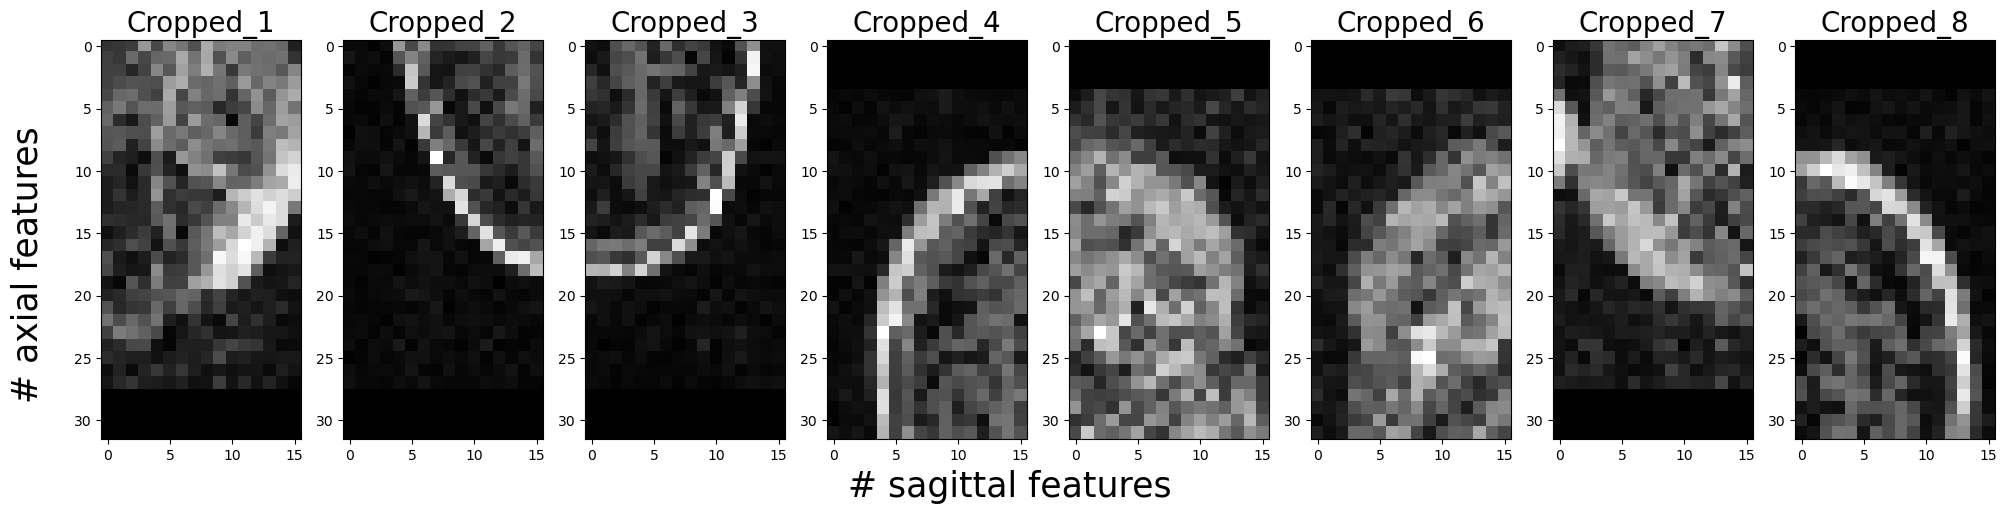

In [112]:
# visualization of different cropped dimensions

indeces = [16, 17, 18, 19, 20, 21, 22, 23]
fig, axes = plt.subplots(1, 8, figsize=(20,20))
fig.supylabel('# axial features', y=0.5, x=0, fontsize=25)
fig.supxlabel('# sagittal features', y=0.38, fontsize=25)

for ax, index in zip(axes, indeces):
    ax.imshow(data.iloc[3][index][:, 20, :], cmap='gray')
    ax.title.set_text(data.columns[index])
    ax.title.set_size(20)
fig.tight_layout()
fig.suptitle(f"Different cropped images based on the second visit of the second patient, label = {data.iloc[3]['Group']}", y=0.65, fontsize=20)
plt.show()

### Full sized images classification

In [38]:
# converting to numpy because that is easier for algorithms
data_num = pd.DataFrame(data).to_numpy()

# defining images and target
for i in range(len(data_num[:, 15])):
    data_num[:, 15][i] = data_num[:, 15][i].reshape(fourth_shape)
    
X = data_num[:, 15]
# stacking so it gets the shape (373, 131072)
X = np.stack(X, axis=0)
y = data_num[:, 2]

# converting strings to integers where 'Nondemented' = 0 and 'Demented' = 1
y = np.where(y == 'Nondemented', 0, 1)

# shuffle because data is ordered
X, y = shuffle(X, y)

##################
#####  KNN  ######
##################

# testing for different amounts of neighbors
n_neighbors = [1, 3, 5, 7, 9, 11]

# cross validation
best = {}
fp = open("CV_scores_KNN_full.txt", "a")
for neighbor in n_neighbors:
    kNN_dict = cross_validate(KNeighborsClassifier(n_neighbors = neighbor), X, y, cv = 10, 
                              n_jobs = 3, return_train_score = True)
    kNN_dict.pop('fit_time')
    kNN_dict.pop('score_time')
    # adding the average and standard error of the folds to a dictionary that keeps scores
    best[neighbor] = np.mean(kNN_dict['test_score']), np.std(kNN_dict['test_score'])
    fp.write(f"KNN with {neighbor} neighbors:\n{kNN_dict}\n")
fp.write(f"Best test score is {max(best.values())[0]} with n_neighbor = {max(best, key=best.get)} and standard deviation {max(best.values())[1]}\n")
fp.close()

##################
#####  SVM  ######
##################

C_value = [1, 50, 100]

best = {}
fp = open("CV_scores_SVM_full.txt", "a")
for value in C_value:
    SVM_dict = cross_validate(svm.SVC(kernel='rbf', C=value), X, y, cv = 10, n_jobs = 3, 
                              return_train_score = True)
    SVM_dict.pop('fit_time')
    SVM_dict.pop('score_time')
    # adding the average and standard error of the folds to a dictionary that keeps scores
    best[value] = np.mean(SVM_dict['test_score']), np.std(SVM_dict['test_score'])
    fp.write(f"SVM with C = {value}:\n{SVM_dict}\n")
fp.write(f"Best test score is {max(best.values())[0]} with C = {max(best, key=best.get)} and standard deviation {max(best.values())[1]}\n")
fp.close()



### Cropped pictures classification

In [39]:
# testing for different neighbors -> KNN
n_neighbors = [1, 3, 5, 7, 9, 11]
# testing for different C values -> SVM
C_value = [1, 50, 100]

# choosing target which is the second column, namely 'Group'
# this stays the same for every cropped picture so shouldn't be in the loop
y = data_num[:, 2]
# converting strings to integers where 'Nondemented' = 0 and 'Demented' = 1
y = np.where(y == 'Nondemented', 0, 1)

best_test_KNN = {}
best_test_SVM = {}
fp = open("CV_scores_KNN_cropped.txt", "a")
file = open("CV_scores_SVM_cropped.txt", "a")

# defining images and target for every cropped picture
for i in range(16, 24):
    for j in range(len(data_num[:, i])):
        data_num[:, i][j] = data_num[:, i][j].reshape(32*32*16)
    X = data_num[:, i]
    # stacking so it gets the shape (373, 16384)
    X = np.stack(X, axis=0)

    # shuffle because data is ordered
    X, y = shuffle(X, y)
  
    fp.write(f"Scores for {data.columns[i]}\n")
    file.write(f"Scores for {data.columns[i]}\n")

    ##################
    #####  KNN  ######
    ##################
    
    best_KNN = {}
    for neighbor in n_neighbors:
        kNN_dict = cross_validate(KNeighborsClassifier(n_neighbors = neighbor), X, y, cv = 10, n_jobs = 3, return_train_score = True)
        kNN_dict.pop('fit_time')
        kNN_dict.pop('score_time')
        # adding the average and standard error of the folds to a dictionary that keeps scores
        best_KNN[neighbor] = np.mean(kNN_dict['test_score']), np.std(kNN_dict['test_score'])
        fp.write(f"KNN with {neighbor} neighbors:\n{kNN_dict}\n")
    # best_test_KNN will have the format {cropped_picture: [(best_mean, standard error), n_neighbors]}
    best_test_KNN[data.columns[i]] = [max(best_KNN.values()), max(best_KNN, key=best_KNN.get)]

    ##################
    #####  SVM  ######
    ##################

    best_SVM = {}
    for value in C_value:
        SVM_dict = cross_validate(svm.SVC(kernel='rbf', C=value), X, y, cv = 10, n_jobs = 3, return_train_score = True)
        SVM_dict.pop('fit_time')
        SVM_dict.pop('score_time')
        # adding the average and standard error of the folds to a dictionary that keeps scores
        best_SVM[value] = np.mean(SVM_dict['test_score']), np.std(SVM_dict['test_score'])
        file.write(f"SVM with C = {value}:\n{SVM_dict}\n")
    # best_test_SVM will have the format {cropped_picture: [(best_mean, standard error), C_value]}
    best_test_SVM[data.columns[i]] = [max(best_SVM.values()), max(best_SVM, key=best_SVM.get)]
     
    fp.write("\n")
    file.write("\n")
    
fp.write(f"{max(best_test_KNN, key=best_test_KNN.get)} has the best test score ({max(best_test_KNN.values())[0][0]}) with n_neighbor = {max(best_test_KNN.values())[1]} and standard deviation {max(best_test_KNN.values())[0][1]} ")
fp.close()
file.write(f"{max(best_test_SVM, key=best_test_SVM.get)} has the best test score ({max(best_test_SVM.values())[0][0]}) with C = {max(best_test_SVM.values())[1]} and standard deviation {max(best_test_SVM.values())[0][1]}")
file.close()


In [40]:
print(best_test_KNN)
print(best_test_SVM)

{'Cropped_1': [(0.5890374331550803, 0.03679200088704873), 7], 'Cropped_2': [(0.5213012477718361, 0.080166801381457), 5], 'Cropped_3': [(0.5776292335115866, 0.0510181634629875), 11], 'Cropped_4': [(0.5445632798573975, 0.05419305266377854), 9], 'Cropped_5': [(0.5388591800356506, 0.08059150576441948), 3], 'Cropped_6': [(0.5296791443850267, 0.03720550845505646), 9], 'Cropped_7': [(0.5620320855614972, 0.06564121204670588), 5], 'Cropped_8': [(0.5746880570409981, 0.0659425726586733), 9]}
{'Cropped_1': [(0.6192513368983958, 0.0715556957170257), 1], 'Cropped_2': [(0.5268270944741532, 0.04385615440968784), 1], 'Cropped_3': [(0.5597147950089127, 0.03952036882157723), 1], 'Cropped_4': [(0.5267379679144385, 0.05107037419995058), 1], 'Cropped_5': [(0.5566844919786098, 0.016502619500547808), 1], 'Cropped_6': [(0.5862745098039215, 0.04853561094350832), 50], 'Cropped_7': [(0.5595365418894831, 0.04526506239947215), 1], 'Cropped_8': [(0.550891265597148, 0.04529953296316884), 1]}


### Focusing on best performing cropped picture
For both SVM and KNN, Cropped_1 performed best

In [41]:
# testing for different neighbors -> KNN
n_neighbors = [1, 3, 5, 7, 9, 11]
# testing for different C values -> SVM
C_value = [1, 50, 100]

# choosing target which is the second column, namely 'Group'
# this stays the same for every cropped picture so shouldn't be in the loop
y = data_num[:, 2]
# converting strings to integers where 'Nondemented' = 0 and 'Demented' = 1
y = np.where(y == 'Nondemented', 0, 1)

best_test_KNN = {}
best_test_SVM = {}
fp = open("CV_scores_KNN_cropped_1.txt", "a")
file = open("CV_scores_SVM_cropped_1.txt", "a")

# defining images and target for every cropped picture
for i in range(24, 28):
    for j in range(len(data_num[:, i])):
        data_num[:, i][j] = data_num[:, i][j].reshape(16*16*16)
    X = data_num[:, i]
    # stacking so it gets the shape (373, 16384)
    X = np.stack(X, axis=0)

    # shuffle because data is ordered
    X, y = shuffle(X, y)
  
    fp.write(f"Scores for {data.columns[i]}\n")
    file.write(f"Scores for {data.columns[i]}\n")

    ##################
    #####  KNN  ######
    ##################
    
    best_KNN = {}
    for neighbor in n_neighbors:
        kNN_dict = cross_validate(KNeighborsClassifier(n_neighbors = neighbor), X, y, cv = 10, n_jobs = 3, return_train_score = True)
        kNN_dict.pop('fit_time')
        kNN_dict.pop('score_time')
        # adding the average and standard error of the folds to a dictionary that keeps scores
        best_KNN[neighbor] = np.mean(kNN_dict['test_score']), np.std(kNN_dict['test_score'])
        fp.write(f"KNN with {neighbor} neighbors:\n{kNN_dict}\n")
    # best_test_KNN will have the format {cropped_picture: [(best_mean, standard error), n_neighbors]}
    best_test_KNN[data.columns[i]] = [max(best_KNN.values()), max(best_KNN, key=best_KNN.get)]

    ##################
    #####  SVM  ######
    ##################

    best_SVM = {}
    for value in C_value:
        SVM_dict = cross_validate(svm.SVC(kernel='rbf', C=value), X, y, cv = 10, n_jobs = 3, return_train_score = True)
        SVM_dict.pop('fit_time')
        SVM_dict.pop('score_time')
        # adding the average and standard error of the folds to a dictionary that keeps scores
        best_SVM[value] = np.mean(SVM_dict['test_score']), np.std(SVM_dict['test_score'])
        file.write(f"SVM with C = {value}:\n{SVM_dict}\n")
    # best_test_SVM will have the format {cropped_picture: [(best_mean, standard error), C_value]}
    best_test_SVM[data.columns[i]] = [max(best_SVM.values()), max(best_SVM, key=best_SVM.get)]
     
    fp.write("\n")
    file.write("\n")
    
fp.write(f"{max(best_test_KNN, key=best_test_KNN.get)} has the best test score ({max(best_test_KNN.values())[0][0]}) with n_neighbor = {max(best_test_KNN.values())[1]} and standard deviation {max(best_test_KNN.values())[0][1]} ")
fp.close()
file.write(f"{max(best_test_SVM, key=best_test_SVM.get)} has the best test score ({max(best_test_SVM.values())[0][0]}) with C = {max(best_test_SVM.values())[1]} and standard deviation {max(best_test_SVM.values())[0][1]}")
file.close()
